# Data Story Assignment

## Determining the effect of weather on TKTS Booth Sales

In this assignment we will compare the weekly sales of the TKTS Booths to the weather that day to determine the extent of the effects of weather on sales at the booths.


In [82]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [83]:
#Get TKTS Sales
#This file contains sales per week, split into the four booths for the year 2016
#Note: Linc booth did not open until late 2016
tktssales = pd.DataFrame.from_csv('data/private/tktssalescombined.csv',index_col=None)
tktssales['WeekEnding'] = pd.to_datetime(tktssales['WeekEnding'])
tktssales['weeknum'] = tktssales.WeekEnding.dt.weekofyear
tktssales.head(10)

,WeekEnding,TiSq,SSSP,Bkln,Linc,TotalSales,weeknum
0,2016-01-10,21099,2789,1022,NaN,24910,1
1,2016-01-17,19945,2920,1036,NaN,23901,2
2,2016-01-24,11920,1200,297,NaN,13417,3
3,2016-01-31,15005,1799,653,NaN,17457,4
4,2016-02-07,15135,1565,626,NaN,17326,5
5,2016-02-14,17430,2262,888,NaN,20580,6
6,2016-02-21,21550,2849,1215,NaN,25614,7
7,2016-02-28,17181,2035,748,NaN,19964,8
8,2016-03-06,18565,2157,764,NaN,21486,9
9,2016-03-13,22034,2727,958,NaN,25719,10


In [84]:
#Load Weather Data
#NOAA Data table is from 1/1/2016 to 12/31/2016
noaafull = pd.DataFrame.from_csv('data/noaaclimatedata2016.csv', index_col=None)
noaafull['DATE'] = pd.to_datetime(noaafull['DATE'])
noaafull.head(10)

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (20,23,25,85,87) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,REPORTTPYE,HOURLYSKYCONDITIONS,HOURLYVISIBILITY,HOURLYPRSENTWEATHERTYPE,...,MonthlyMaxSeaLevelPressureTime,MonthlyMinSeaLevelPressureValue,MonthlyMinSeaLevelPressureDate,MonthlyMinSeaLevelPressureTime,MonthlyTotalHeatingDegreeDays,MonthlyTotalCoolingDegreeDays,MonthlyDeptFromNormalHeatingDD,MonthlyDeptFromNormalCoolingDD,MonthlyTotalSeasonToDateHeatingDD,MonthlyTotalSeasonToDateCoolingDD
0,WBAN:94728,NY CITY CENTRAL PARK NY US,39.6,40.7889,-73.9669,2016-01-01 00:51:00,FM-15,OVC:08 37,10,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
1,WBAN:94728,NY CITY CENTRAL PARK NY US,39.6,40.7889,-73.9669,2016-01-01 01:51:00,FM-15,OVC:08 36,10,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
2,WBAN:94728,NY CITY CENTRAL PARK NY US,39.6,40.7889,-73.9669,2016-01-01 02:51:00,FM-15,OVC:08 34,10,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
3,WBAN:94728,NY CITY CENTRAL PARK NY US,39.6,40.7889,-73.9669,2016-01-01 03:51:00,FM-15,OVC:08 31,10,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
4,WBAN:94728,NY CITY CENTRAL PARK NY US,39.6,40.7889,-73.9669,2016-01-01 04:51:00,FM-15,OVC:08 44,10,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
5,WBAN:94728,NY CITY CENTRAL PARK NY US,39.6,40.7889,-73.9669,2016-01-01 05:51:00,FM-15,OVC:08 35,10,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
6,WBAN:94728,NY CITY CENTRAL PARK NY US,39.6,40.7889,-73.9669,2016-01-01 06:51:00,FM-15,OVC:08 36,10,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
7,WBAN:94728,NY CITY CENTRAL PARK NY US,39.6,40.7889,-73.9669,2016-01-01 07:51:00,FM-15,OVC:08 36,10,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
8,WBAN:94728,NY CITY CENTRAL PARK NY US,39.6,40.7889,-73.9669,2016-01-01 08:51:00,FM-15,FEW:02 38,10,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
9,WBAN:94728,NY CITY CENTRAL PARK NY US,39.6,40.7889,-73.9669,2016-01-01 09:51:00,FM-15,OVC:08 35,10,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN


# Building our table
## We will build a table using the loaded data
We will build one table with the columns that we will use in our study
We only have sales data by week, so we will have to group our temperatures on a weekly basis.

In [111]:
#Build a dataframe of temps
#1. We only need the rows where REPORTTYPE is FM-15
#2. We only need the temps while the booth is open: 11AM to 8PM (11:00 to 20:00)
#3. Several temps are available.  We will use HOURLYDRYBULBTEMPF since that is closest to what people feel

temps = noaafull[noaafull.REPORTTPYE == 'FM-15']
temps = temps[((temps.DATE.dt.hour >= 11) & (temps.DATE.dt.hour <= 20))]
temps.head(10)

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,REPORTTPYE,HOURLYSKYCONDITIONS,HOURLYVISIBILITY,HOURLYPRSENTWEATHERTYPE,...,MonthlyMaxSeaLevelPressureTime,MonthlyMinSeaLevelPressureValue,MonthlyMinSeaLevelPressureDate,MonthlyMinSeaLevelPressureTime,MonthlyTotalHeatingDegreeDays,MonthlyTotalCoolingDegreeDays,MonthlyDeptFromNormalHeatingDD,MonthlyDeptFromNormalCoolingDD,MonthlyTotalSeasonToDateHeatingDD,MonthlyTotalSeasonToDateCoolingDD
11,WBAN:94728,NY CITY CENTRAL PARK NY US,39.6,40.7889,-73.9669,2016-01-01 11:51:00,FM-15,OVC:08 36,10,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
12,WBAN:94728,NY CITY CENTRAL PARK NY US,39.6,40.7889,-73.9669,2016-01-01 12:51:00,FM-15,OVC:08 37,10,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
13,WBAN:94728,NY CITY CENTRAL PARK NY US,39.6,40.7889,-73.9669,2016-01-01 13:51:00,FM-15,OVC:08 40,10,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
14,WBAN:94728,NY CITY CENTRAL PARK NY US,39.6,40.7889,-73.9669,2016-01-01 14:51:00,FM-15,BKN:07 39 OVC:08 47,10,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
15,WBAN:94728,NY CITY CENTRAL PARK NY US,39.6,40.7889,-73.9669,2016-01-01 15:51:00,FM-15,OVC:08 60,10,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
16,WBAN:94728,NY CITY CENTRAL PARK NY US,39.6,40.7889,-73.9669,2016-01-01 16:51:00,FM-15,CLR:00,10,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
17,WBAN:94728,NY CITY CENTRAL PARK NY US,39.6,40.7889,-73.9669,2016-01-01 17:51:00,FM-15,CLR:00,10,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
18,WBAN:94728,NY CITY CENTRAL PARK NY US,39.6,40.7889,-73.9669,2016-01-01 18:51:00,FM-15,FEW:02 60,10,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
19,WBAN:94728,NY CITY CENTRAL PARK NY US,39.6,40.7889,-73.9669,2016-01-01 19:51:00,FM-15,CLR:00,10,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
20,WBAN:94728,NY CITY CENTRAL PARK NY US,39.6,40.7889,-73.9669,2016-01-01 20:51:00,FM-15,CLR:00,10,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
#Add a Date Column (without the hour) so we can group by
temps['dayval'] = temps['DATE'].dt.day.astype(str)
temps['monthval'] = temps['DATE'].dt.month.astype(str)
temps['yearval'] = temps['DATE'].dt.year.astype(str)
temps['date'] = temps.yearval.str.cat(temps.monthval, sep='-').str.cat(temps.dayval, sep='-')
temps['date'] = pd.to_datetime(temps['date'])

#then add weeknum column and temp column
temps['temp'] = temps.HOURLYDRYBULBTEMPF
temps['weeknum'] = temps.DATE.dt.weekofyear

#then add precipiation (Some values = 'T'. We will remove this so that we can sum this value)
temps['precip'] = temps.HOURLYPrecip
temps.precip = temps.precip.replace('T',0)
temps.precip = temps.precip.fillna(0)
temps.precip = temps.precip.astype(float)

#Trim the DataFrame down to just the columns we want
temps = temps[['date','temp','weeknum','precip']]

temps.head(50)

,date,temp,weeknum,precip
11,2016-01-01,40.0,53,0.0
12,2016-01-01,40.0,53,0.0
13,2016-01-01,40.0,53,0.0
14,2016-01-01,39.0,53,0.0
15,2016-01-01,39.0,53,0.0
16,2016-01-01,38.0,53,0.0
17,2016-01-01,38.0,53,0.0
18,2016-01-01,37.0,53,0.0
19,2016-01-01,37.0,53,0.0
20,2016-01-01,36.0,53,0.0


In [87]:
#Calculate Averages by Day
tempsDay = temps.set_index('date')
tempsDay = temps.groupby('date').temp.mean()
tempsDay.head(10)

date
2016-01-01    38.4
2016-01-02    37.6
2016-01-03    41.4
2016-01-04    24.1
2016-01-05    26.9
2016-01-06    37.9
2016-01-07    44.0
2016-01-08    43.5
2016-01-09    45.9
2016-01-10    55.5
Name: temp, dtype: float64

In [88]:
#Calculate Averages, Highs, Lows, and Precipitation by Week
tempsWeekAvg = temps.groupby('weeknum').temp.mean()
tempsWeekHigh = temps.groupby('weeknum').temp.max()
tempsWeekLow = temps.groupby('weeknum').temp.min()
tempsWeekPrecip = temps.groupby('weeknum').precip.sum()

#Assemble a dataframe with these columns
tempsWeekDf = pd.DataFrame(tempsWeekAvg)
tempsWeekDf['tempHigh'] = tempsWeekHigh
tempsWeekDf['tempLow'] = tempsWeekLow
tempsWeekDf['precip'] = tempsWeekPrecip
tempsWeekDf = tempsWeekDf.reset_index()
tempsWeekDf = tempsWeekDf.rename(columns={"temp":"tempAvg"})
tempsWeekDf

,weeknum,tempAvg,tempHigh,tempLow,precip
0,1,39.685714,59.0,18.0,0.06
1,2,37.485714,51.0,24.0,0.05
2,3,29.342857,36.0,20.0,1.20
3,4,41.614286,55.0,34.0,0.00
4,5,46.342857,59.0,32.0,0.73
5,6,25.200000,38.0,6.0,0.03
6,7,42.157143,61.0,23.0,1.10
7,8,44.057143,60.0,30.0,1.00
8,9,41.271429,60.0,32.0,0.04
9,10,62.200000,78.0,50.0,0.00


In [89]:
#Merge two datasets
tktssales.set_index('weeknum')
salesTemps = tktssales.merge(tempsWeekDf)
salesTemps.head(10)

,WeekEnding,TiSq,SSSP,Bkln,Linc,TotalSales,weeknum,tempAvg,tempHigh,tempLow,precip
0,2016-01-10,21099,2789,1022,NaN,24910,1,39.685714,59.0,18.0,0.06
1,2016-01-17,19945,2920,1036,NaN,23901,2,37.485714,51.0,24.0,0.05
2,2016-01-24,11920,1200,297,NaN,13417,3,29.342857,36.0,20.0,1.20
3,2016-01-31,15005,1799,653,NaN,17457,4,41.614286,55.0,34.0,0.00
4,2016-02-07,15135,1565,626,NaN,17326,5,46.342857,59.0,32.0,0.73
5,2016-02-14,17430,2262,888,NaN,20580,6,25.200000,38.0,6.0,0.03
6,2016-02-21,21550,2849,1215,NaN,25614,7,42.157143,61.0,23.0,1.10
7,2016-02-28,17181,2035,748,NaN,19964,8,44.057143,60.0,30.0,1.00
8,2016-03-06,18565,2157,764,NaN,21486,9,41.271429,60.0,32.0,0.04
9,2016-03-13,22034,2727,958,NaN,25719,10,62.200000,78.0,50.0,0.00


In [90]:
#Assign a "comfort index" to a new column
#For cold temps 0 to 3 from pleasant to bitter cold
#For warm temps 0 to 3 from pleasant to very hot

salesTemps['comfIndex'] = np.nan
salesTemps.ix[((salesTemps.tempHigh>=95)),'comfIndex'] = 3
salesTemps.ix[((salesTemps.tempHigh>=90) & (salesTemps.tempHigh<95)),'comfIndex'] = 2
salesTemps.ix[((salesTemps.tempHigh>=85) & (salesTemps.tempHigh<90)),'comfIndex'] = 1
salesTemps.ix[((salesTemps.tempLow<=25)),'comfIndex'] = 3
salesTemps.ix[((salesTemps.tempLow>25) & (salesTemps.tempLow<=35)),'comfIndex'] = 2
salesTemps.ix[((salesTemps.tempLow>35) & (salesTemps.tempLow<=50)),'comfIndex'] = 1

salesTemps.ix[(salesTemps.comfIndex.isnull()),'comfIndex'] = 0

salesTemps = salesTemps.sort_values(by='weeknum')
salesTemps.head(10)


,WeekEnding,TiSq,SSSP,Bkln,Linc,TotalSales,weeknum,tempAvg,tempHigh,tempLow,precip,comfIndex
0,2016-01-10,21099,2789,1022,NaN,24910,1,39.685714,59.0,18.0,0.06,3.0
1,2016-01-17,19945,2920,1036,NaN,23901,2,37.485714,51.0,24.0,0.05,3.0
2,2016-01-24,11920,1200,297,NaN,13417,3,29.342857,36.0,20.0,1.20,3.0
3,2016-01-31,15005,1799,653,NaN,17457,4,41.614286,55.0,34.0,0.00,2.0
4,2016-02-07,15135,1565,626,NaN,17326,5,46.342857,59.0,32.0,0.73,2.0
5,2016-02-14,17430,2262,888,NaN,20580,6,25.200000,38.0,6.0,0.03,3.0
6,2016-02-21,21550,2849,1215,NaN,25614,7,42.157143,61.0,23.0,1.10,3.0
7,2016-02-28,17181,2035,748,NaN,19964,8,44.057143,60.0,30.0,1.00,2.0
8,2016-03-06,18565,2157,764,NaN,21486,9,41.271429,60.0,32.0,0.04,2.0
9,2016-03-13,22034,2727,958,NaN,25719,10,62.200000,78.0,50.0,0.00,1.0


# Analyzing the Data

We will now examine the data in our table to see if we can find any trends

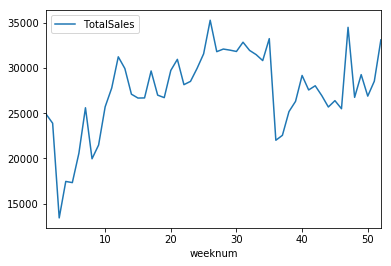

In [91]:
#First we plot the sales for the week from week 26 to week 52
salesTemps.sort_values(by='weeknum').plot(x='weeknum', y='TotalSales')

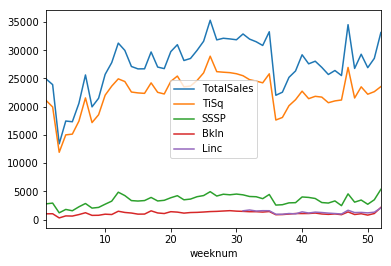

In [92]:
#Sales by Booth
salesTemps.sort_values(by='weeknum').plot(x='weeknum',y=['TotalSales','TiSq','SSSP','Bkln','Linc'])

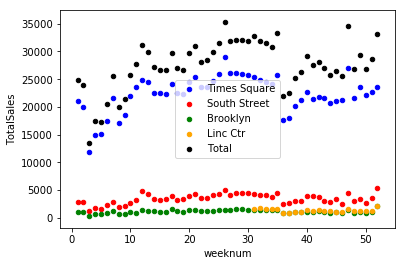

In [93]:
#Sales by Booth
TiSq = salesTemps.plot.scatter(x='weeknum', y='TiSq', color='Blue', label='Times Square')
SSSP = salesTemps.plot.scatter(x='weeknum', y='SSSP', color='Red', label='South Street',ax=TiSq)
Bkln = salesTemps.plot.scatter(x='weeknum', y='Bkln', color='Green', label='Brooklyn', ax=SSSP)
Linc = salesTemps.plot.scatter(x='weeknum', y='Linc', color='Orange', label='Linc Ctr', ax=Bkln)
All = salesTemps.plot.scatter(x='weeknum', y='TotalSales', color='Black', label='Total', ax=Linc)


#df.plot.scatter(x='c', y='d', color='DarkGreen', label='Group 2', ax=ax);

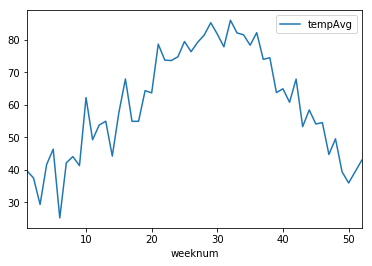

In [94]:
#We plot Avg Temperature by week just to see the trend
salesTemps.sort_values(by='weeknum').plot(x='weeknum', y='tempAvg')

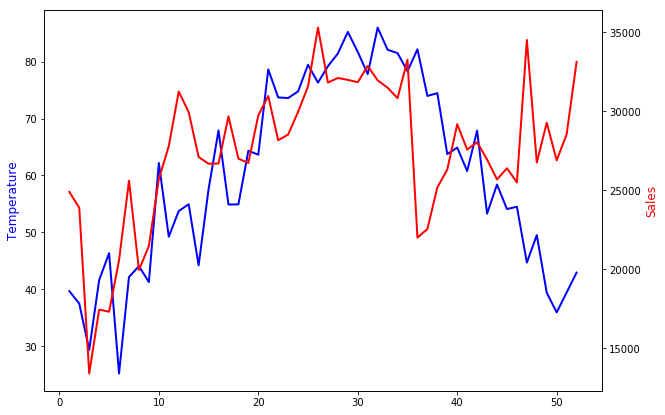

In [95]:
#Plot Temp against TotalSales
x = salesTemps.weeknum
y = salesTemps.tempAvg
z = salesTemps.TotalSales
fig,ax1 = plt.subplots(figsize=(10,7))
ax1.plot(x,y,lw=2,color='blue')
ax1.set_ylabel(r"Temperature",fontsize=12,color='blue')
ax2 = ax1.twinx()
ax2.plot(x,z,lw=2,color='red')
ax2.set_ylabel(r"Sales",fontsize=12,color='red')

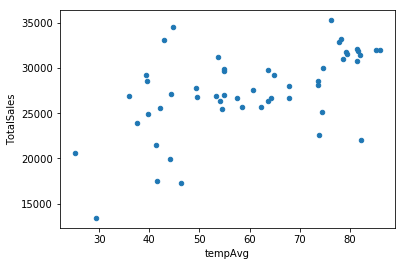

In [96]:
#We do a scatterplot of Avg Temp vs sales to see if there is any correlation
# We can see that there is very little correlation between temps and sales
# Running a scatterplot with High Temps and Low Temps reveal similarly shaped plots (no correlation)

salesTemps.plot(x='tempAvg',y='TotalSales',kind='scatter')

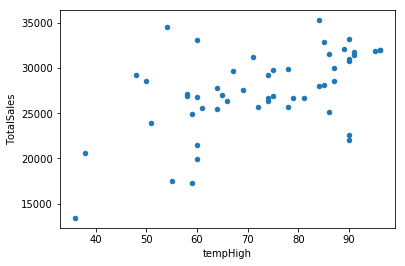

In [97]:
#We do a scatterplot of Avg Temp vs sales to see if there is any correlation
# We can see that there is very little correlation between temps and sales
# Running a scatterplot with High Temps and Low Temps reveal similarly shaped plots (no correlation)

salesTemps.plot(x='tempHigh',y='TotalSales',kind='scatter')

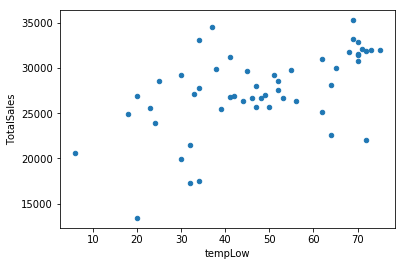

In [98]:
#We do a scatterplot of Avg Temp vs sales to see if there is any correlation
# We can see that there is very little correlation between temps and sales
# Running a scatterplot with High Temps and Low Temps reveal similarly shaped plots (no correlation)

salesTemps.plot(x='tempLow',y='TotalSales',kind='scatter')

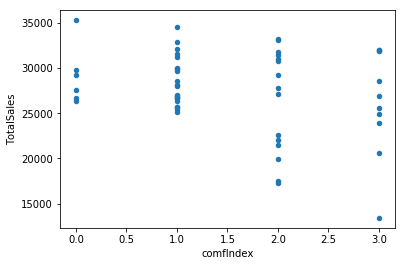

In [99]:
#We now run a scatterplot vs the relative comfort of the temparature.
#  Where 0 is extremely comfortable and great weather to be outside
#  And 3 is either extremely hot or extemely cold

#We can see below that extreme weather has no effect on sales
#If anything, great weather has perhaps a negative effect on sales
#Otherwise, there is generally no correlation between temperature and sales

salesTemps.plot(x='comfIndex',y='TotalSales',kind='scatter')

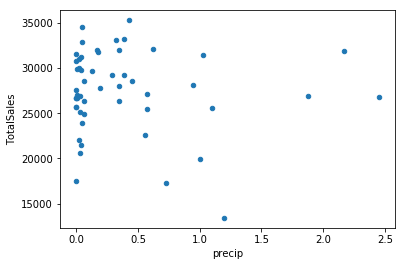

In [100]:
#We now run a scatterplot of sales against precipitation (rain or snow)

#Again, we see very little to no correlation between precipiation and sales

salesTemps.plot(x='precip',y='TotalSales',kind='scatter')

# Conclusions

It has been generally assumed that the weather plays a large role in sales at the TKTS booths, since the booths are located outdoors.  However, we can see that the weather has no visible effect on sales at the booths.

Perhaps we can derive further insights by examining booth sales per day instead of per week.  (Sales data per day is not available at the moment.)  We might hypothesize that any decrease in sales is offset by the patrons simply going to the theatre on a different day of the week when it is nicer.

So what factors do affect sales at the booth?

In [101]:
#A possible factor is the week of the year
#While the thanksgiving and christmas holidays have no effect (in fact, sales are great during those weeks),
# we can see below the the weeks with the least sales is the week of the Fourth of July, the week of Labor Day,
# and the week immediately after that (perhaps because the children are in school and the parents want to relax).
# These are weeks of major summer holidays when people spend time outside.
tktssales.sort_values(by = 'TotalSales').head(3)

,WeekEnding,TiSq,SSSP,Bkln,Linc,TotalSales,weeknum
2,2016-01-24,11920,1200,297,NaN,13417,3
4,2016-02-07,15135,1565,626,NaN,17326,5
3,2016-01-31,15005,1799,653,NaN,17457,4
